In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
import numpy as np
from shapely.geometry import MultiPoint
from matplotlib.colors import LogNorm
import psycopg2

In [51]:
file_path =  "taxi_data.txt"

In [52]:
df = pd.read_csv(file_path, header = None, names = ['timestamp','longitude','latitude'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [53]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs = "EPSG:4326"
)

In [54]:
print(gdf.head())

            timestamp  longitude  latitude                    geometry
1 2008-02-02 15:36:08  116.51172  39.92123  POINT (116.51172 39.92123)
1 2008-02-02 15:46:08  116.51135  39.93883  POINT (116.51135 39.93883)
1 2008-02-02 15:46:08  116.51135  39.93883  POINT (116.51135 39.93883)
1 2008-02-02 15:56:08  116.51627  39.91034  POINT (116.51627 39.91034)
1 2008-02-02 16:06:08  116.47186  39.91248  POINT (116.47186 39.91248)


In [55]:
gdf = gdf.to_crs(epsg = 3857)
gdf['prev_point'] = gdf.geometry.shift()
gdf['distance_m'] = gdf.geometry.distance(gdf['prev_point']).fillna(0)

In [56]:
gdf['distance_m']

1       0.000000
1    2555.299826
1       0.000000
1    4171.634717
1    4953.444600
        ...     
1    5026.993324
1    3208.425659
1    3519.791166
1    4802.311611
1    2835.311351
Name: distance_m, Length: 588, dtype: float64

Vehicle that travelled longest distance

In [ ]:
total_distance_km = gdf['distance_m'].sum() / 1000
print(f"Total distance travelled: {total_distance_km:.2f} km")

Total distance travelled: 575.40 km


Identifying stops

In [58]:
gdf['time_diff_sec'] = gdf['timestamp'].diff().dt.total_seconds().fillna(0)
gdf['stop'] = (gdf['distance_m'] < 5) & (gdf['time_diff_sec'] >= 900)
stops = gdf[gdf['stop']].copy()
stops = stops.drop_duplicates(subset='geometry')
buffer_500 = stops.copy()
buffer_500['geometry'] = buffer_500.geometry.buffer(500)

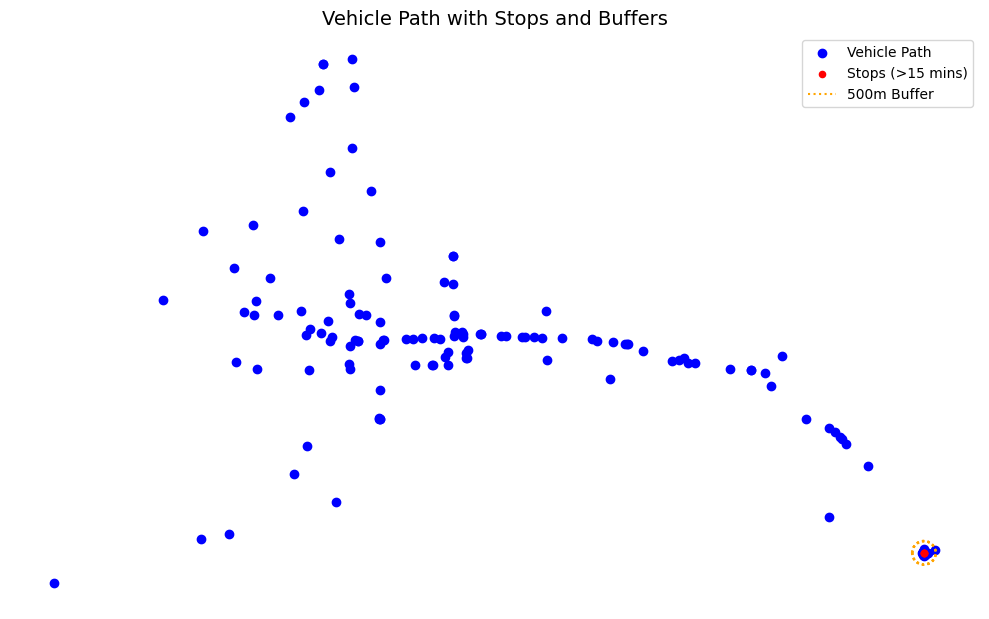

In [ ]:
gdf_utm = gdf.to_crs(epsg=3857)
stops_utm = stops.to_crs(epsg=3857)
buffer_500_utm = buffer_500.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))

gdf_utm.plot(ax=ax, color='blue', linewidth=1, label='Vehicle Path')

stops_utm.plot(ax=ax, color='red', markersize=20, label='Stops (>15 mins)')

buffer_500_utm.boundary.plot(ax=ax, color='orange', linestyle=':', label='500m Buffer')

ax.set_title("Vehicle Path with Stops and Buffers", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()


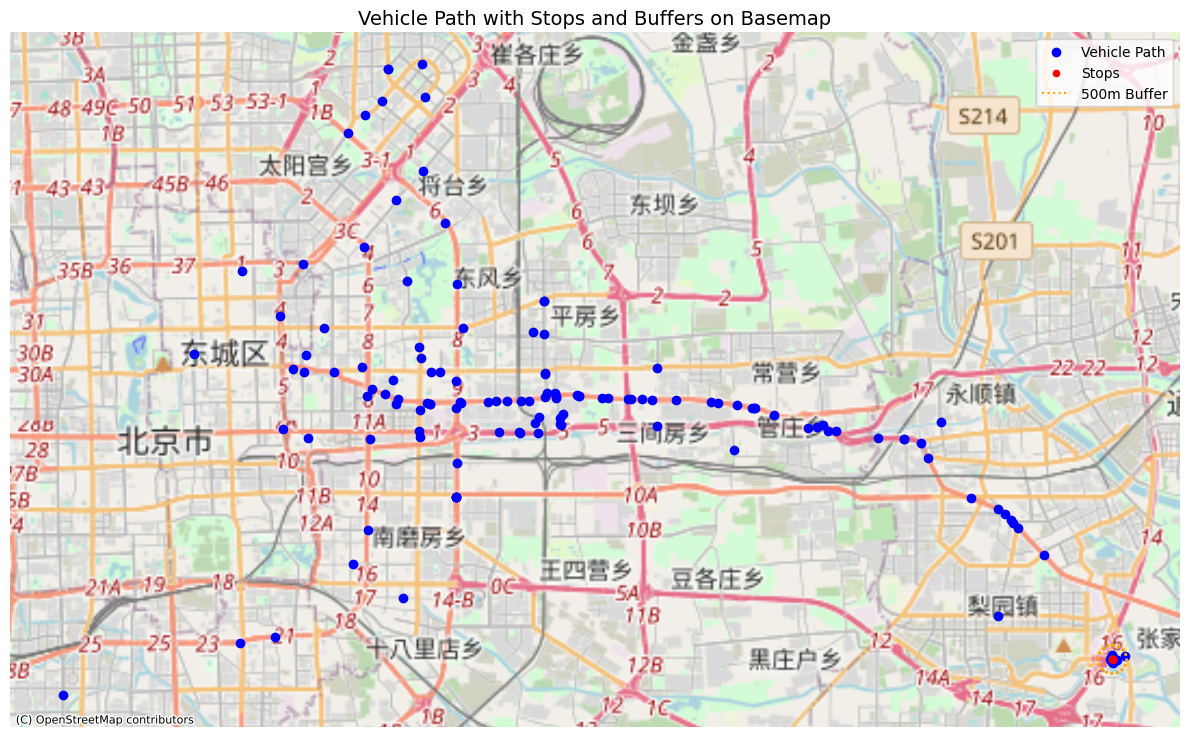

In [60]:
gdf_utm = gdf.to_crs(epsg=3857)
stops_utm = stops.to_crs(epsg=3857)
buffer_500_utm = buffer_500.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

gdf_utm.plot(ax=ax, color='blue', linewidth=1, label='Vehicle Path')
stops_utm.plot(ax=ax, color='red', markersize=20, label='Stops')
buffer_500_utm.boundary.plot(ax=ax, color='orange', linestyle=':', label='500m Buffer')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Vehicle Path with Stops and Buffers on Basemap", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()

-> used multiple vehicles from here onwards

In [ ]:
folder_path = 'release/taxi_log_2008_by_id'
all_data = []

for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        vehicle_id = filename.split('.')[0]
        file_path = os.path.join(folder_path, filename)

        df = pd.read_csv(file_path, header=None, names=['timestamp', 'longitude', 'latitude'])
        if df.empty:
            continue
        
        df = df.dropna(subset=['timestamp', 'longitude', 'latitude'])
        if df.empty:
            continue

        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.dropna(subset=['timestamp'])
        if df.empty:
            continue

        df['vehicle_id'] = vehicle_id
        all_data.append(df)

if len(all_data) == 0:
    raise ValueError("No valid data found in the folder!")

df_all = pd.concat(all_data, ignore_index=True)

gdf_all = gpd.GeoDataFrame(
    df_all,
    geometry=gpd.points_from_xy(df_all['longitude'], df_all['latitude']),
    crs="EPSG:4326"
)
gdf_all = gdf_all.sort_values(by=['vehicle_id', 'timestamp'])
gdf_all = gdf_all.to_crs(epsg=3857)

2.1 Neighbourhoods/areas with most activity

In [71]:
china_l2 = gpd.read_file("beijing/gadm41_CHN_2.shp")
beijing = china_l2[china_l2["NAME_1"] == "Beijing"].to_crs(epsg=3857)
beijing = beijing.to_crs(epsg=3857)

In [72]:
gdf_all = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf_all = gdf_all.to_crs(epsg=3857)


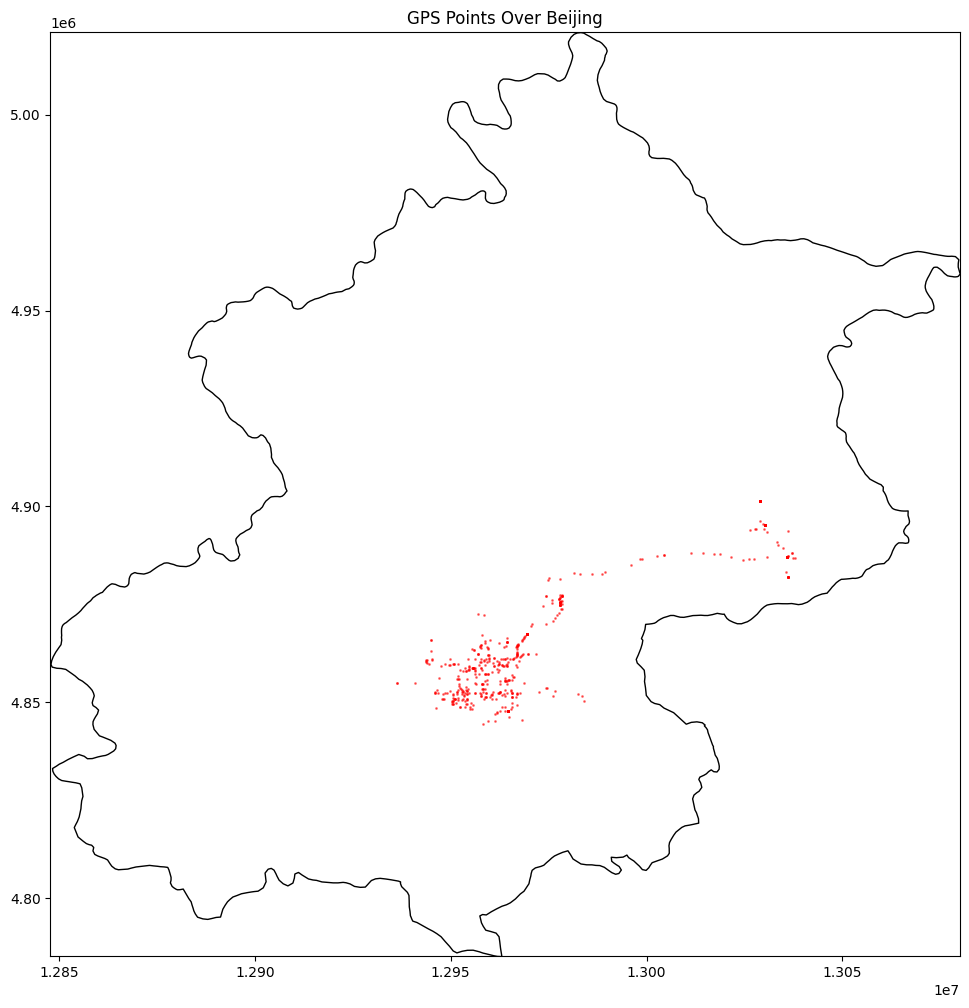

In [73]:
gdf_beijing = gpd.sjoin(gdf_all, beijing, predicate='within')

activity = gdf_beijing.groupby("NAME_2").size().reset_index(name="vehicle_activity")

beijing_activity = beijing.merge(activity, on="NAME_2", how="left")
beijing_activity["vehicle_activity"] = beijing_activity["vehicle_activity"].fillna(0)

xmin, ymin, xmax, ymax = beijing.total_bounds

fig, ax = plt.subplots(figsize=(12, 12))
beijing.plot(ax=ax, color='white', edgecolor='black')
gdf_all.plot(ax=ax, color='red', markersize=1, alpha=0.5)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title("GPS Points Over Beijing")
plt.show()

2.2 average speed between GPS points

In [78]:
gdf_all = gdf_all.sort_values(by=['vehicle_id', 'timestamp']).reset_index(drop=True)

gdf_all['prev_geometry'] = gdf_all.groupby('vehicle_id')['geometry'].shift()
gdf_all['distance_m'] = gdf_all.apply(
    lambda row: row['geometry'].distance(row['prev_geometry']) if pd.notnull(row['prev_geometry']) else np.nan,
    axis=1
)

gdf_all['prev_timestamp'] = gdf_all.groupby('vehicle_id')['timestamp'].shift()
gdf_all['time_diff_s'] = (gdf_all['timestamp'] - gdf_all['prev_timestamp']).dt.total_seconds()

gdf_all['avg_speed_m_s'] = gdf_all['distance_m'] / gdf_all['time_diff_s']

gdf_all['avg_speed_km_h'] = gdf_all['avg_speed_m_s'] * 3.6

gdf_all.loc[gdf_all['avg_speed_km_h'] > 200, 'avg_speed_km_h'] = np.nan

print(gdf_all[['vehicle_id', 'timestamp', 'distance_m', 'time_diff_s', 'avg_speed_km_h']].head(10))

  vehicle_id           timestamp  distance_m  time_diff_s  avg_speed_km_h
0         99 2008-02-02 13:54:05         NaN          NaN             NaN
1         99 2008-02-02 14:14:04    1.113195       1199.0        0.003342
2         99 2008-02-02 14:24:04   11.614489        600.0        0.069687
3         99 2008-02-02 14:34:04    4.368827        600.0        0.026213
4         99 2008-02-02 14:44:05    4.684868        601.0        0.028062
5         99 2008-02-02 14:54:05    8.534975        600.0        0.051210
6         99 2008-02-02 15:14:04   18.033715       1199.0        0.054146
7         99 2008-02-02 15:24:04   17.510763        600.0        0.105065
8         99 2008-02-02 15:34:04    9.806839        600.0        0.058841
9         99 2008-02-02 15:44:04   55.740360        600.0        0.334442


2.3 Identifying Stops

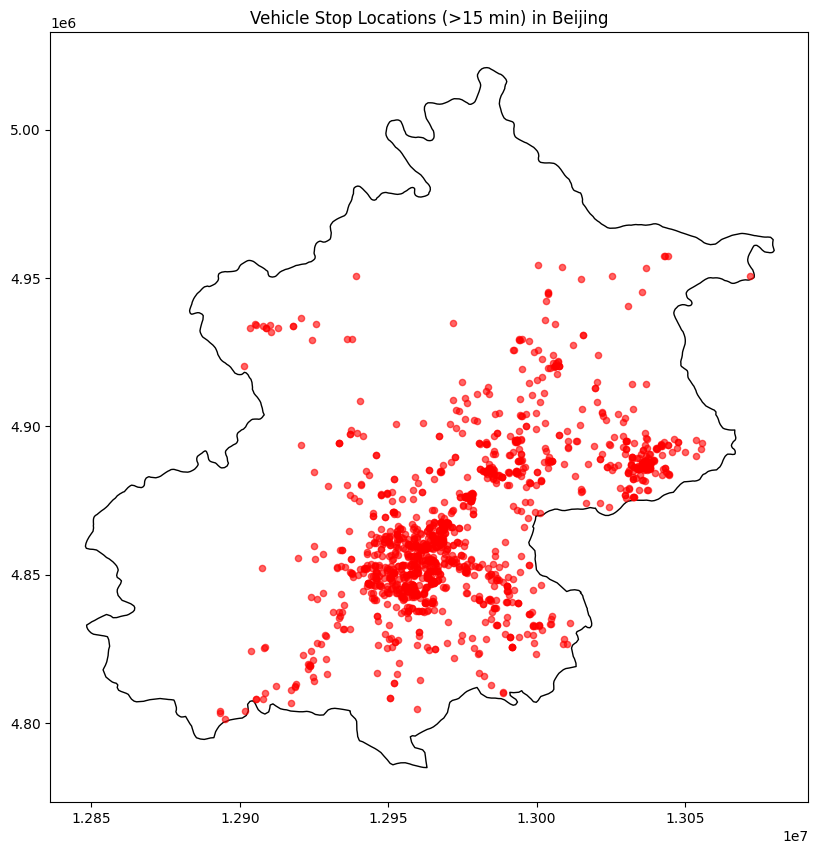

In [ ]:
stop_time_threshold = 15 * 60  
stop_distance_threshold = 30

gdf_all['time_diff'] = gdf_all.groupby('vehicle_id')['timestamp'].diff().dt.total_seconds()
gdf_all['distance_diff'] = gdf_all.geometry.distance(gdf_all.groupby('vehicle_id')['geometry'].shift())

gdf_all['is_stop_point'] = (gdf_all['time_diff'] > stop_time_threshold) & (gdf_all['distance_diff'] < stop_distance_threshold)

stops = gdf_all[gdf_all['is_stop_point']].copy()
stops['rounded_x'] = stops.geometry.x.round(-2)
stops['rounded_y'] = stops.geometry.y.round(-2)

stop_locations = stops.groupby(['rounded_x', 'rounded_y']).agg({
    'geometry': lambda x: MultiPoint(x).centroid,
    'vehicle_id': 'nunique'
}).reset_index()

stop_locations = gpd.GeoDataFrame(stop_locations, geometry='geometry', crs=gdf_all.crs)

beijing = china_l2[china_l2['NAME_1'] == 'Beijing']
stop_locations_beijing = gpd.sjoin(stop_locations, beijing, predicate='within', how='inner')

base = beijing.plot(color='white', edgecolor='black', figsize=(10, 10))
stop_locations_beijing.plot(ax=base, color='red', markersize=20, alpha=0.6)
plt.title("Vehicle Stop Locations (>15 min) in Beijing")
plt.show()


2.4 Heatmap of vehicle density

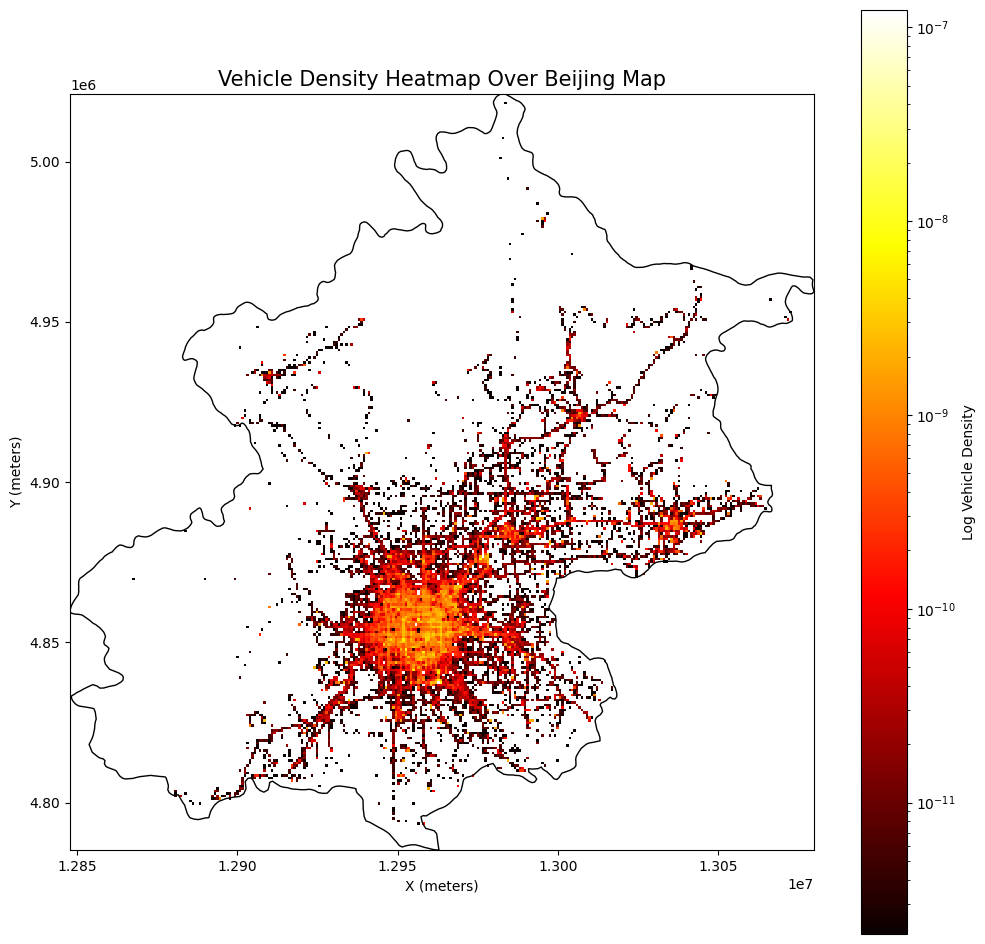

In [ ]:
bounds = beijing.total_bounds
minx, miny, maxx, maxy = bounds

fig, ax = plt.subplots(figsize=(12, 12))

beijing.boundary.plot(ax=ax, color='black', linewidth=1)

heatmap = ax.hist2d(
    x, y,
    bins=300,
    range=[[minx, maxx], [miny, maxy]],
    cmap='hot',
    density=True,
    norm=LogNorm()
)

plt.colorbar(heatmap[3], ax=ax, label="Log Vehicle Density")

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title("Vehicle Density Heatmap Over Beijing Map", fontsize=15)
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
ax.set_aspect('equal')

plt.show()

3.1 Grouping Data by hour of day

In [99]:
gdf_all['hour'] = gdf_all['timestamp'].dt.hour
gdf_all['hour']

0         15
1         15
2         15
3         15
4         16
          ..
789552    16
789553    17
789554    17
789555    17
789556    17
Name: hour, Length: 789557, dtype: int32

3.2 Summary Statistics

In [103]:
gdf_all = gdf_all.sort_values(by=['vehicle_id', 'timestamp']).reset_index(drop=True)

gdf_all['prev_geometry'] = gdf_all.groupby('vehicle_id')['geometry'].shift()
gdf_all['distance_m'] = gdf_all.apply(
    lambda row: row['geometry'].distance(row['prev_geometry']) if row['prev_geometry'] else 0,
    axis=1
)

gdf_all['prev_timestamp'] = gdf_all.groupby('vehicle_id')['timestamp'].shift()
gdf_all['time_diff_s'] = (gdf_all['timestamp'] - gdf_all['prev_timestamp']).dt.total_seconds().fillna(0)

gdf_all['speed_m_s'] = np.where(
    gdf_all['time_diff_s'] > 0,
    gdf_all['distance_m'] / gdf_all['time_diff_s'],
    0
)

gdf_all = gdf_all[gdf_all['time_diff_s'] > 0].reset_index(drop=True)
summary_by_hour = gdf_all.groupby('hour').agg(
    total_records = ('vehicle_id', 'count'),
    unique_vehicles = ('vehicle_id', 'nunique'),
    avg_speed = ('speed_m_s', 'mean')
).reset_index()

print(summary_by_hour)


    hour  total_records  unique_vehicles   avg_speed
0      0          28532              444  227.559670
1      1          25846              425   12.936534
2      2          16999              403    7.610836
3      3          22287              391   11.226569
4      4          21304              377  436.040404
5      5          21492              330   15.265356
6      6          21741              338  181.074152
7      7          21779              361   24.246318
8      8          23138              407  322.478170
9      9          26729              445   21.410588
10    10          31702              461  310.104596
11    11          34448              473  501.651025
12    12          36317              476   90.810406
13    13          39283              472   59.302731
14    14          41778              468  214.785349
15    15          40442              473   20.302349
16    16          42386              472   65.885559
17    17          40250              467   20.

3.3 Identifying peak activity hours

In [ ]:
peak_by_records = summary_by_hour.loc[summary_by_hour['total_records'].idxmax(), 'hour']
peak_by_vehicles = summary_by_hour.loc[summary_by_hour['unique_vehicles'].idxmax(), 'hour']

print(f"Peak activity hour by total GPS records: {peak_by_records}")
print(f"Peak activity hour by unique vehicles: {peak_by_vehicles}")

Peak activity hour by total GPS records: 16
Peak activity hour by unique vehicles: 12
